In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PosPuc/TCC/datasets/result_models/results_nn.csv')

In [ ]:
df[df.loss == min(df.loss)]

,optimizer,layers_size,layers,epochs,activation,loss,mae
41,Adam,128,2,300,gelu,22.867411,2.72772


In [ ]:
df[df.mae == min(df.mae)]

,optimizer,layers_size,layers,epochs,activation,loss,mae
38,Adam,128,2,300,relu,23.566145,2.706093


In [ ]:
# Get train dataset
df_train = pd.read_csv('/content/drive/MyDrive/PosPuc/TCC/datasets/df_processeds/x_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/PosPuc/TCC/datasets/df_processeds/y_train.csv')

In [ ]:
# Encoding variables
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore').fit(df_train)

# Encode train dataset
x_train = ohe.transform(df_train).toarray()

# Change y_train values to float
y_train = y_train.astype('float32')

In [ ]:
# Checking GPU use
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Install scikeras
!pip install scikeras[tensorflow] &> /dev/null

In [ ]:
# Build model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

def built_model(meta):
    
    hidden = []
    
    hidden.append(Input(meta["n_features_in_"]))
    for _ in range(2):
        hidden.append(Dense(128, activation='gelu'))
        hidden.append(Dropout(0.2))
    
    hidden += [Dense(64, activation='gelu'), Dropout(0.2), Dense(1)]

    model = Sequential(hidden)
    
    return model

In [ ]:
# Using cross validation nested to check best epoch size and activation

# Para utilização do grid search do scikit-learn necessário uso
# do KerasRegressor do scikeras.wrappers

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

sc = 'neg_mean_absolute_error'

params = {'random_state': [42],
          'epochs': [100, 200, 300]}

model_params = {
    'loss': 'mse',
    'optimizer': Adam(),
    'metrics': [tf.keras.metrics.MeanAbsoluteError()],
    'verbose': False,
    'batch_size': 100
}

model = KerasRegressor(built_model, **model_params)
gs = GridSearchCV(model, param_grid=params, cv=5, scoring=sc, refit=True, n_jobs=-1)
gs.fit(x_train, y_train.values.ravel())

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5,
             estimator=KerasRegressor(batch_size=100, loss='mse', metrics=[<keras.metrics.MeanAbsoluteError object at 0x7fa17f5ebbd0>], model=<function built_model at 0x7fa1945155f0>, optimizer=<keras.optimizer_v2.adam.Adam object at 0x7fa17f315c90>, verbose=False),
             n_jobs=-1,
             param_grid={'epochs': [100, 200, 300], 'random_state': [42]},
             scoring='neg_mean_absolute_error')

In [ ]:
gs.best_estimator_

KerasRegressor(
	model=<function built_model at 0x7fa1945155f0>
	build_fn=None
	warm_start=False
	random_state=42
	optimizer=<keras.optimizer_v2.adam.Adam object at 0x7fa17f480890>
	loss=mse
	metrics=[<keras.metrics.MeanAbsoluteError object at 0x7fa17f2ed210>]
	batch_size=100
	validation_batch_size=None
	verbose=False
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
)

In [ ]:
gs.best_score_

-2.9876804828643797

In [ ]:
results = pd.DataFrame(gs.cv_results_)
results.to_csv('/content/drive/MyDrive/PosPuc/TCC/datasets/df_processeds/grid_result_gelu2.csv', index=False, encoding='utf8')

In [ ]:
# Training and saving model

def built_model():
    
    hidden = []
    
    hidden.append(Input(shape=(x_train.shape[1],)))
    for _ in range(2):
        hidden.append(Dense(128, activation='gelu'))
        hidden.append(Dropout(0.2))
    
    hidden += [Dense(64, activation='gelu'), Dropout(0.2), Dense(1)]

    model = Sequential(hidden)

    model.compile(
        loss='mse', 
        optimizer=Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    return model

fit_params = {'epochs': 100, 'batch_size': 100, 'verbose': False}

model = built_model()
model.fit(x_train, y_train.values.ravel(), **fit_params)

filepath = '/content/drive/MyDrive/PosPuc/TCC/model/regressor_model_gelu2'

tf.keras.models.save_model(
    model, 
    filepath, 
    overwrite=True,
    include_optimizer=True)

In [ ]:
# Predictions test with best estimator

# Load test and validation datasets
df_test = pd.read_csv('/content/drive/MyDrive/PosPuc/TCC/datasets/df_processeds/x_test.csv')
y_test = pd.read_csv('/content/drive/MyDrive/PosPuc/TCC/datasets/df_processeds/y_test.csv')

df_valid = pd.read_csv('/content/drive/MyDrive/PosPuc/TCC/datasets/df_processeds/x_valid.csv')
y_valid = pd.read_csv('/content/drive/MyDrive/PosPuc/TCC/datasets/df_processeds/y_valid.csv')

# Encoding 
x_test = ohe.transform(df_test).toarray()
x_valid = ohe.transform(df_valid).toarray()

# Charge model
model = tf.keras.models.load_model('/content/drive/MyDrive/PosPuc/TCC/model/regressor_model_gelu2')

from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score

y_test_pred = model.predict(x_test)
print(f'MAE: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MDAE: {median_absolute_error(y_test, y_test_pred)}')
print(f'R2: {r2_score(y_test, y_test_pred)}\n\n')

y_valid_pred = model.predict(x_valid)
print(f'MAE: {mean_absolute_error(y_valid, y_valid_pred)}')
print(f'MDAE: {median_absolute_error(y_valid, y_valid_pred)}')
print(f'R2: {r2_score(y_valid, y_valid_pred)}')

MAE: 3.0502662922082333
MDAE: 1.3667738437652588
R2: 0.8984063782940498


MAE: 2.975739397005138
MDAE: 1.3571653366088867
R2: 0.8964060156354174


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_style('dark')

In [ ]:
def prep_graph(y_test, y_pred, size):
    y_test = [i for i in y_test['pessoas'].values.tolist()[0:size]]
    y_pred = [int(i) for i in y_pred.ravel()[0:size]]
    df = pd.DataFrame({'y_real': y_test, 'y_hat': y_pred})
    return df

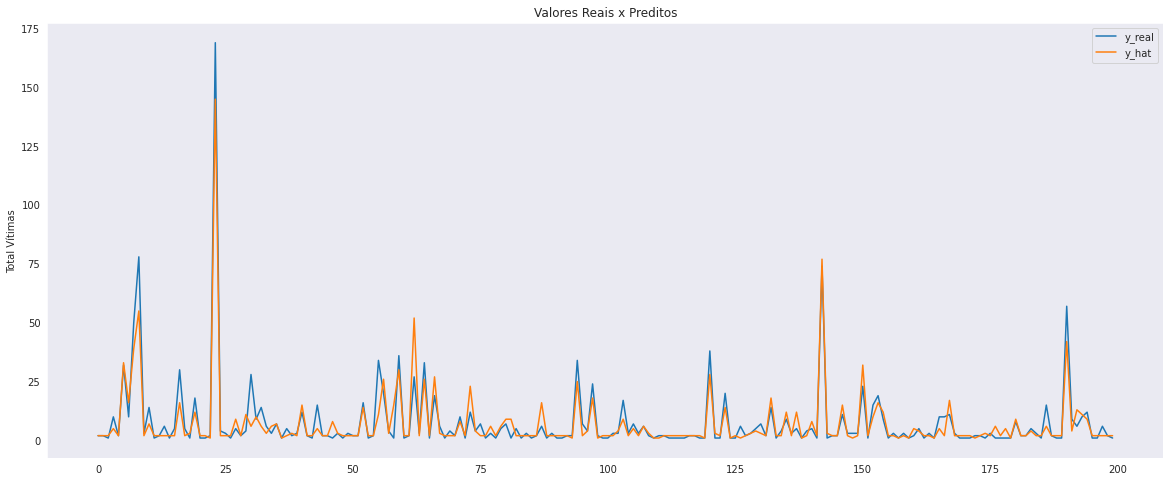

In [ ]:
plt.figure(figsize=(20, 8))
p = sns.lineplot(data=prep_graph(y_test, y_test_pred, 200), dashes=False)
p.set(title='Valores Reais x Preditos', ylabel='Total Vítimas')
plt.legend(labels=['y_real', 'y_hat'])
plt.show()

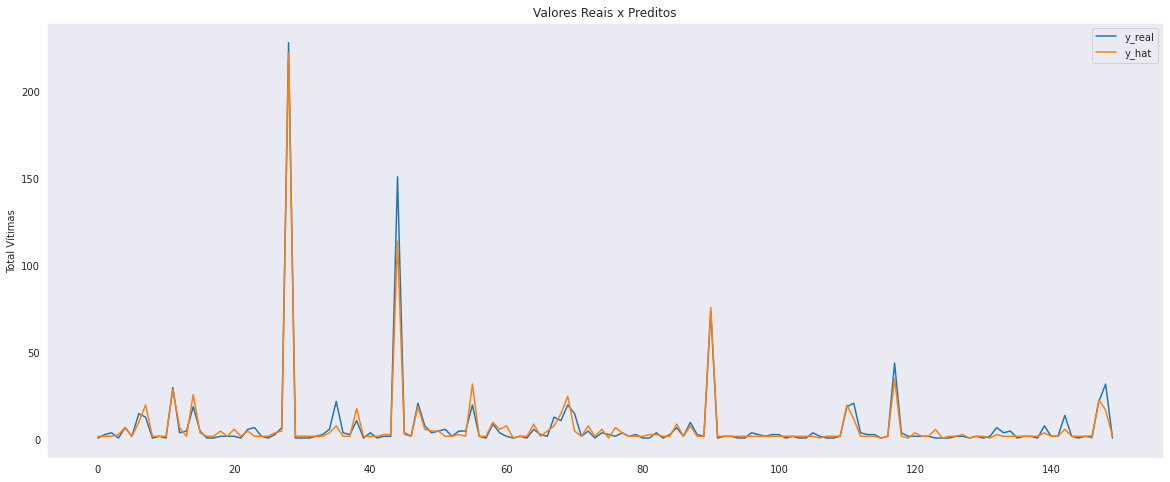

In [ ]:
plt.figure(figsize=(20, 8))
p = sns.lineplot(data=prep_graph(y_valid, y_valid_pred, 200), dashes=False)
p.set(title='Valores Reais x Preditos', ylabel='Total Vítimas')
plt.legend(labels=['y_real', 'y_hat'])
plt.show()